In [1]:
# MUST be executed first, as sometimes causes the kernel to die and makes it inconvinient, since everything will need to be rerun
import pyopencl as cl
cl.create_some_context()

: 

: 

# Create a sphere
* specify size of a box in nm, it wil be centered around 0
* specify the resolution of the axis with nPoints - make it an odd number (if running LOCALLY, DO NOT set it bigger than 101)
* optionally specify the volume fraction, up until which the vox will be filled, default is 0.05
* call a `place_shape` function to create spheres in a box, specify `single=True` if you want to create just a single sphere
* when calling a `place_shape` you can also specify such parameters as rMean and rWidth to sample radius and length from a normal distribution with certain mean and standard deviation.  

In [1]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

In [2]:
simulation = Sphere(size = 10, nPoints = 801, volFrac = 0.05)
simulation.place_shape(nonoverlapping=False)

volume fraction is 0.00010, radius is 0.29, center at (1.9,3.6,-3.5) 
volume fraction is 0.00020, radius is 0.29, center at (-1.7,2.0,1.9) 
volume fraction is 0.00023, radius is 0.19, center at (3.0,0.6,-4.1) 
volume fraction is 0.00027, radius is 0.20, center at (-3.8,-2.3,-2.0) 
volume fraction is 0.00031, radius is 0.21, center at (4.1,2.2,1.1) 
volume fraction is 0.00031, radius is 0.00, center at (4.1,-3.1,-2.3) 
volume fraction is 0.00031, radius is 0.11, center at (4.4,2.7,-1.2) 
volume fraction is 0.00032, radius is 0.14, center at (-1.4,-3.1,2.2) 
volume fraction is 0.00039, radius is 0.25, center at (-1.2,3.1,2.9) 
volume fraction is 0.00041, radius is 0.17, center at (4.8,0.1,0.9) 
volume fraction is 0.00042, radius is 0.11, center at (4.9,-0.1,-4.6) 
volume fraction is 0.00060, radius is 0.35, center at (2.4,4.5,1.0) 
volume fraction is 0.00066, radius is 0.25, center at (-2.9,-2.2,-3.1) 
volume fraction is 0.00068, radius is 0.17, center at (-3.5,1.1,-3.0) 
volume fraction

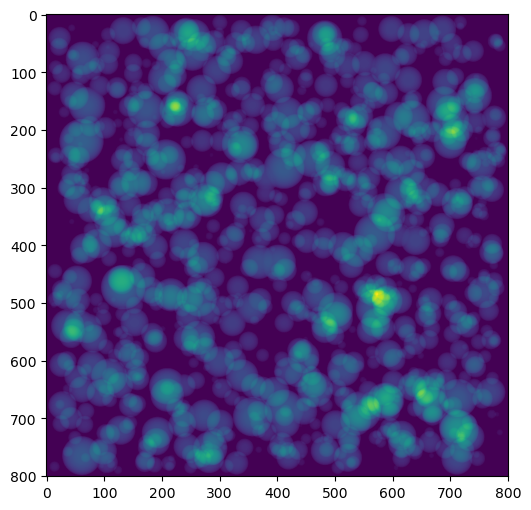

In [3]:
# the box summed on X-axis
plt.figure(figsize=(6,6))
plt.imshow(simulation.density.sum(axis=0));

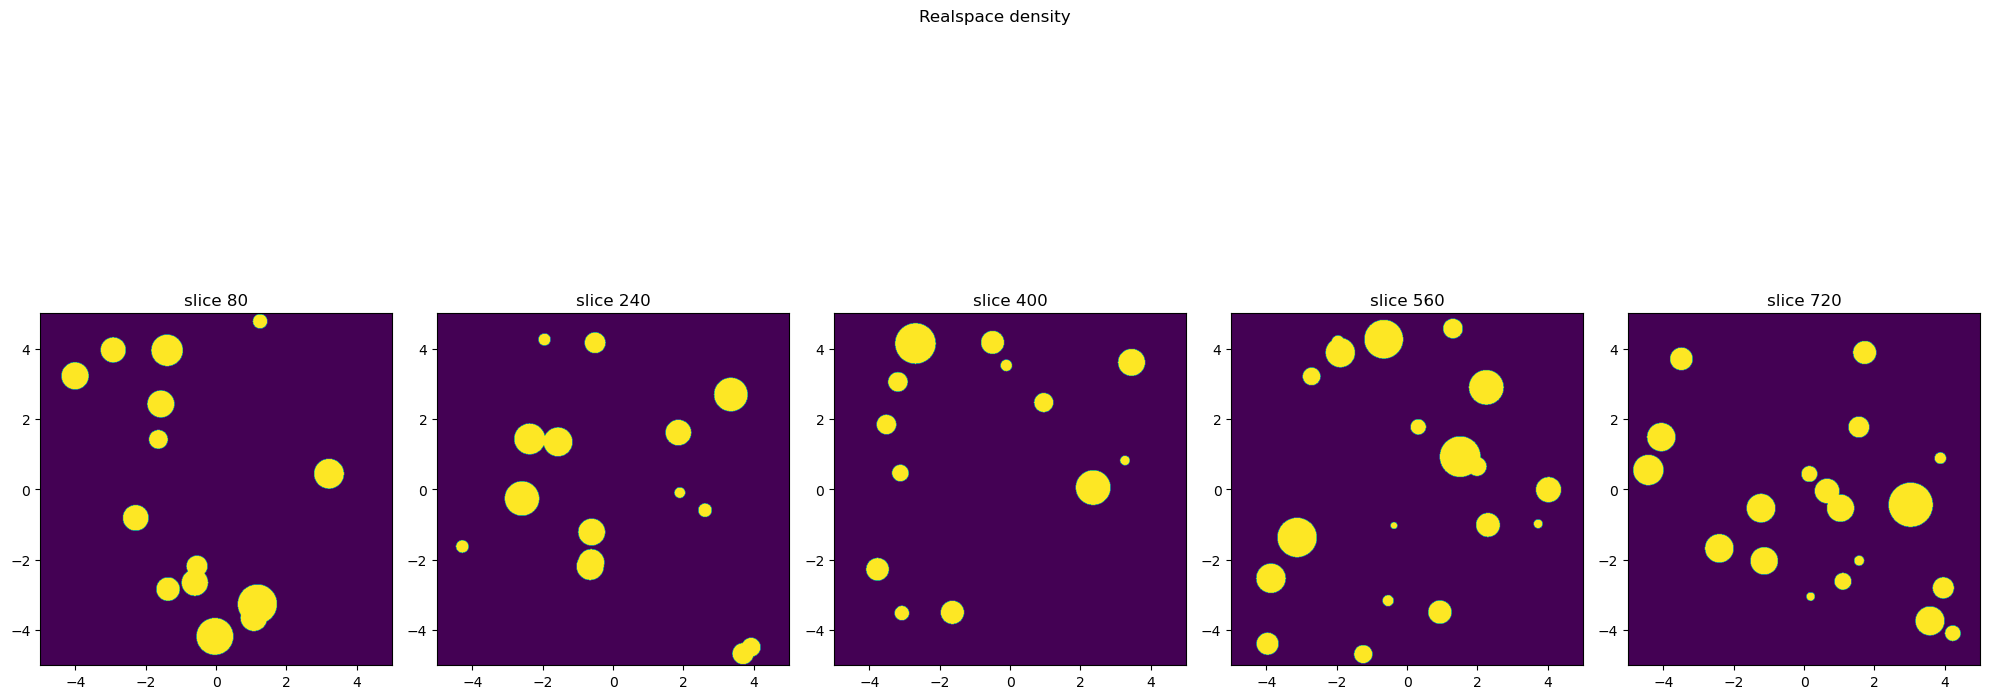

In [15]:
# plot the sampled density at 5 equally-distances slices
plot_slices(simulation.density, simulation.grid)

In [6]:
# takes some time
# plot_3D_structure(simulation.density, simulation.grid, realspace=True)

In [4]:
# pin memory for the GPU usage
# don't need to run when no PGU available
simulation.pin_memory()

## There are few options to calculate the Fourier Transform of a structure:
1) with a class method `calculate_custom_FTI_3D_slice` - custom calculator for a central slice only
2) with a class method `calculate_custom_FTI_3D` - custom calculator for the whole 3D Fourier transform of a structure density
3) with a class method `calculate_torch_FTI_3D` - calls torch's fftn, also speciies value for a central slice as an attribute

In [17]:
# calculate FT at central slice, specify device to 'cpu' if no GPUs available
simulation.calculate_custom_FTI_3D_slice(device = 'cuda') 

RuntimeError: CUDA out of memory. Tried to allocate 7.66 GiB (GPU 0; 15.75 GiB total capacity; 7.66 GiB already allocated; 7.21 GiB free; 7.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [5]:
simulation.calculate_custom_per_axis(device = 'cuda')

/home/slaskina/SAXS-simulations/SAXSsimulations/create_form.py:71: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352657443/work/aten/src/ATen/native/Copy.cpp:250.)
  if FT[:,i,j].any():


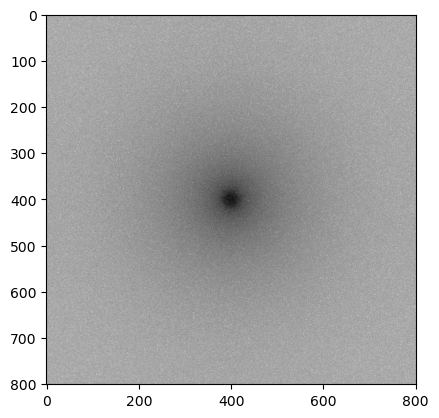

In [7]:
plt.imshow(np.log(simulation.FTI_slice_custom_per_axis), cmap = 'Greys')

In [9]:
#simulation.calculate_custom_FTI_3D(device = 'cpu')
simulation.calculate_torch_FTI_3D(device = 'cuda')

the maximal difference between the implementation of the FTI is 0.010551334817578199


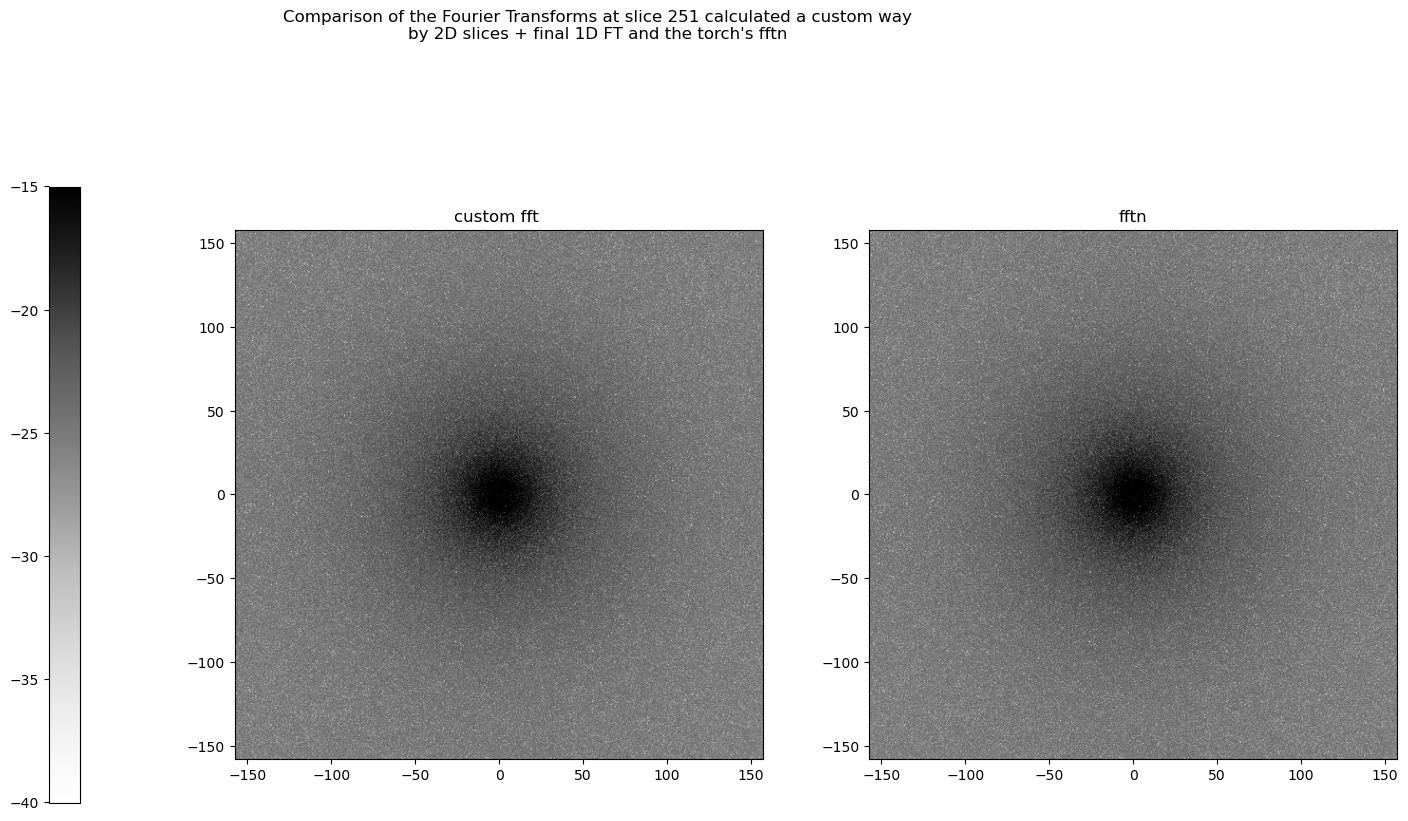

In [10]:
#difference in fft of central slice
plot_FTI_version(simulation.FTI_slice_custom, simulation.FTI_slice_torch, simulation.qx)

In [11]:
# don't plot on big scale, takes time!
# import torch
#plot_3D_structure(torch.from_numpy(simulation.FTI), simulation.qx, realspace= False)#, path = 'figures/FFT_spheres_example.png')

## The rebinning procedure. 
* before that iternally applies the sinc function
* specify the number of bins
* note, that rebinning is not performed for all calculated intensities, but only for those within the sphere inside of a box to achieve more consistent averaged values, since the "corner" values are under-represented
* after the rebinning is done, remove the very first bin, because it always contains 1 point and is the smallest possible angle, which just represents the scaling of Q 

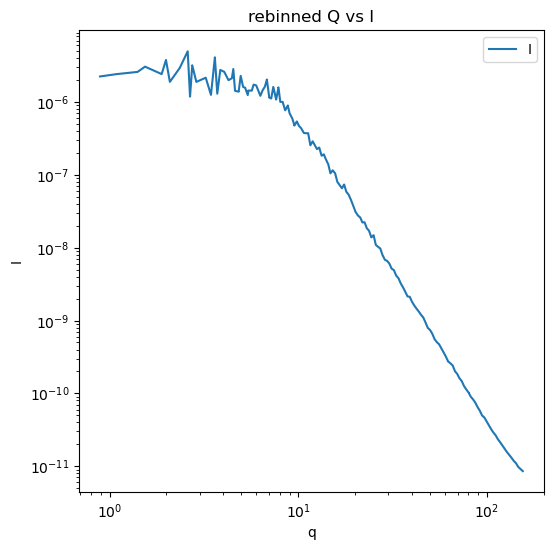

In [12]:
simulation.reBin(200, slice = 'center')
simulation.drop_first_bin()
plot_Q_vs_I(simulation.binned_slice)

## Comparing to SasModels
* uses the SasModells API under the hood
* initializes the model with same values for radius and polidispersity as for simulated spheres in a box (sets background to 0, SLD to 1 and SLD solvent to 0)
* initialization is performed for same values of Q, as present after the rebinning 
* plots the comparison between Sphere simulation in a box and a SasModels simulation



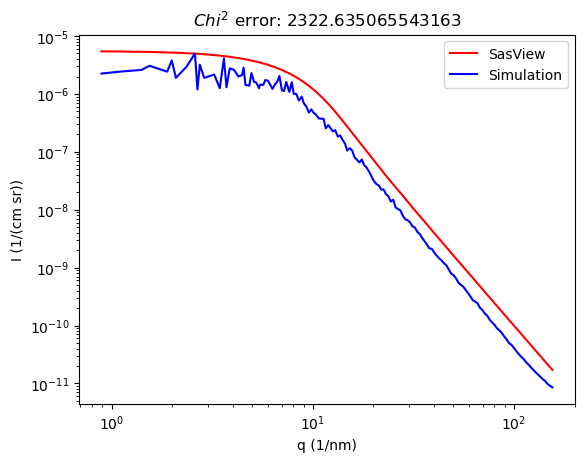

In [13]:
simulation.init_sas_model()
plot_simulation_vs_sas( simulation)

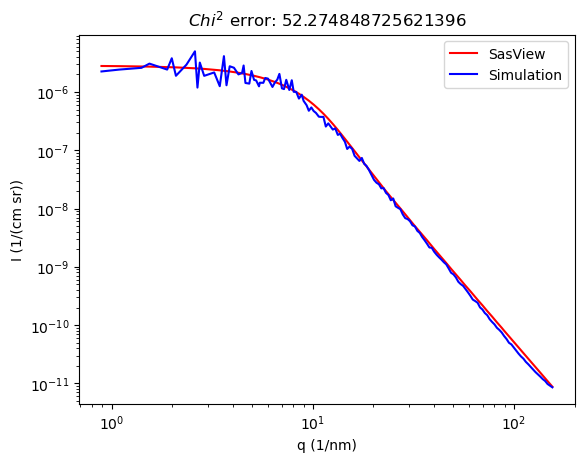

In [14]:
simulation.optimize_scaling()
plot_simulation_vs_sas( simulation)

In [15]:
simulation.modelParameters_sas['scale']

array([0.51269081])

In [16]:
simulation.save_data(uncertainty =  'IError',directory='dat_files')
print("the sphere file with radius {r:.3f}  is saved".format(r = simulation.rMean))

the sphere file with radius 0.066  is saved


# Create a Cylinder
Similarly define the box where a cylinder will be placed and then call a function to place cylinders. One can again specify the argument to create just one cylinder, and also create cylinders of certain size by specifying rMean, hMean and rWidth hWidth to sample cylinders of certain radius and length and specifying theta and phi for the angles.
Currently creates cylinders such that one of the angles is aligned with some axis in a box.

In [2]:
from SAXSsimulations import  Sphere, Cylinder
from SAXSsimulations.plotting import *

simulation = Cylinder(size = 10, nPoints = 513, volFrac = 0.05)
simulation.place_shape()

rMean -0.04961702643676803
rMean -0.1686327097503872
rMean 0.27443810749331177
volume fraction is 0.00017, height is 2.991, radius is 0.134, center at (-1.3,-2.1,-1.7), rotation phi is 264, rotation theta is 0 
volume fraction is 0.00080, height is 2.766, radius is 0.269, center at (0.9,4.3,2.2), rotation phi is 319, rotation theta is 0 
volume fraction is 0.00084, height is 3.089, radius is 0.063, center at (1.5,4.2,1.2), rotation phi is 270, rotation theta is -3 
volume fraction is 0.00163, height is 3.139, radius is 0.285, center at (2.2,-1.3,-2.3), rotation phi is 192, rotation theta is 3 
volume fraction is 0.00301, height is 3.011, radius is 0.383, center at (3.3,-0.1,-3.7), rotation phi is 340, rotation theta is -6 
volume fraction is 0.00424, height is 3.250, radius is 0.348, center at (-1.9,-4.4,-1.9), rotation phi is 34, rotation theta is 0 
volume fraction is 0.00442, height is 2.996, radius is 0.136, center at (0.1,3.4,-3.4), rotation phi is 345, rotation theta is 7 
volume

In [ ]:
# takes a while 
#plot_3D_structure(simulation.density, simulation.grid, realspace=True)

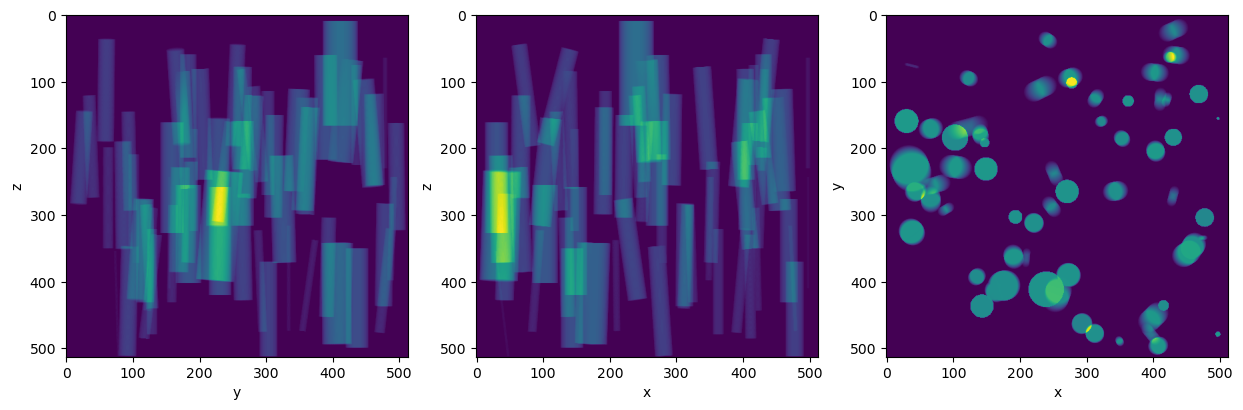

In [3]:
#plot_slices(simulation.density, simulation.grid, direction ='z')
# look at the sum on each slice
plt_slices_sum(simulation)

In [4]:
simulation.pin_memory()

compare the central slices of custom and torch's implementation

the maximal difference between the implementation of the FTI is 0.029087716188618044


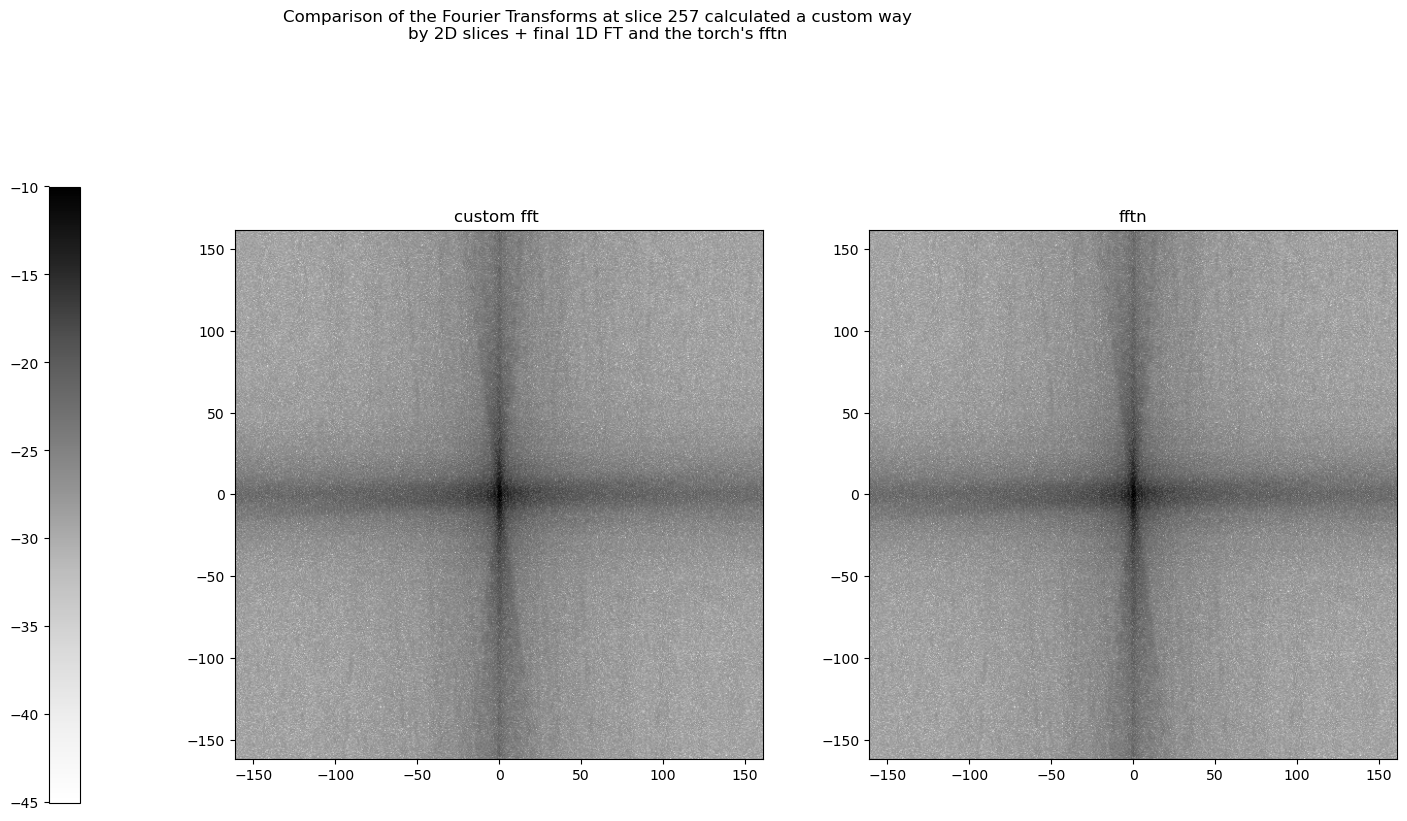

In [5]:
simulation.calculate_custom_FTI_3D_slice(device = 'cuda')
simulation.calculate_torch_FTI_3D(device = 'cuda')

plot_FTI_version(simulation.FTI_slice_custom, simulation.FTI_slice_torch, simulation.qx)

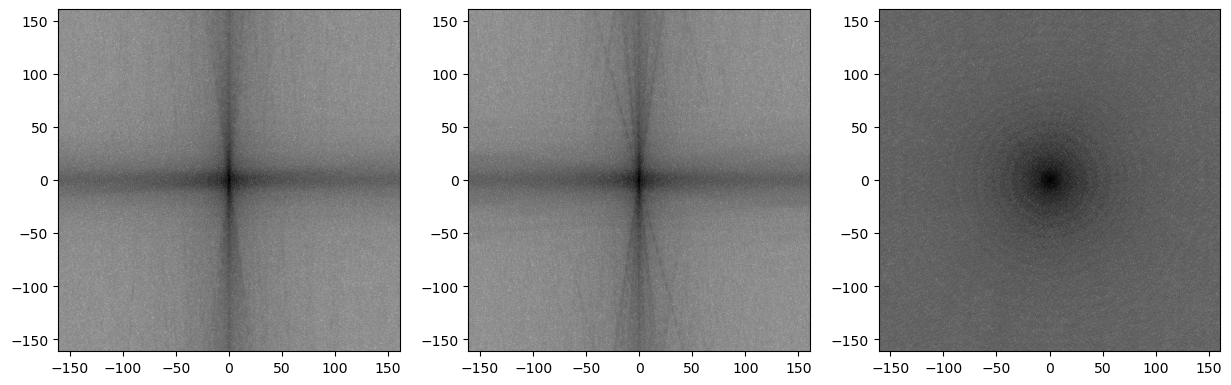

In [6]:
simulation.calculate_custom_FTI_3D(device = 'cuda')
plt_slices_ft(simulation)

### this function allows to look at the central slice of FT in any direction
but for it to work, we need to calculate FT for the whole box

In [7]:
simulation.reBin(400)

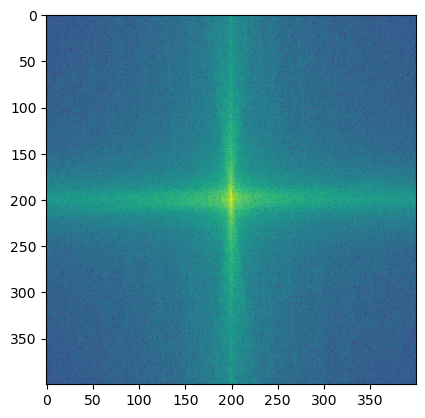

In [8]:
plt.imshow(np.log(simulation.binned_slice['I'].values.reshape(400,400)))

In [9]:
simulation.init_sas_model()
simulation.Chi_squared_norm( 'ISigma')

start creating (160000,)
kernel done
model done


298047612.42243946

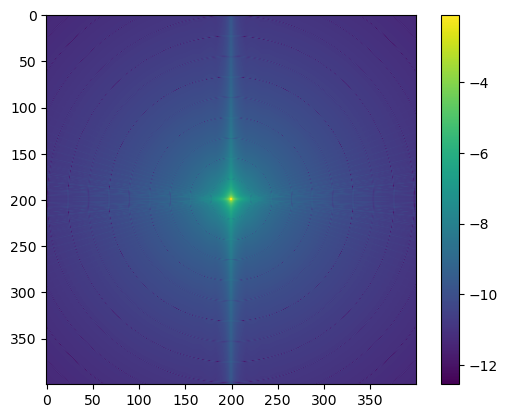

In [10]:
plot_2d_sas(simulation.I_sas)

start creating (160000,)
kernel done
model done
$Chi^2$ error: 25942.065009651975


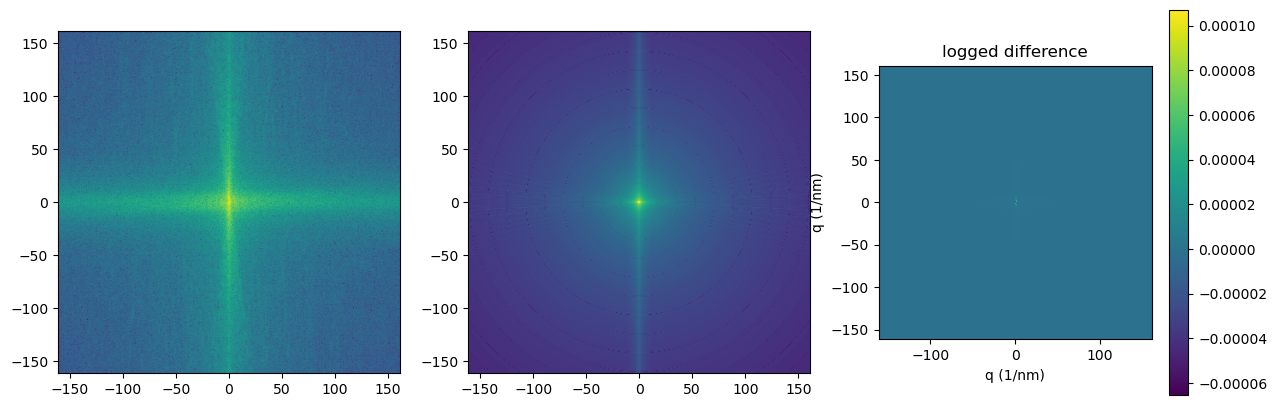

In [11]:
simulation.optimize_scaling()
plot_simulation_vs_sas( simulation)

In [12]:
simulation.modelParameters_sas

{'scale': array([0.00933369]),
 'background': 0.0,
 'sld': 1.0,
 'sld_solvent': 0.0,
 'radius': 2.7443810749331177,
 'length': 30.436112019044828,
 'theta': 0,
 'phi': 0,
 'up_frac_i': 0.0,
 'up_frac_f': 0.0,
 'up_angle': 0.0,
 'up_phi': 0.0,
 'sld_M0': 0.0,
 'sld_mtheta': 0.0,
 'sld_mphi': 0.0,
 'sld_solvent_M0': 0.0,
 'sld_solvent_mtheta': 0.0,
 'sld_solvent_mphi': 0.0,
 'radius_pd': 0.3643808832286058,
 'radius_pd_type': 'gaussian',
 'radius_pd_n': 35,
 'length_pd': 0.049283561548906216,
 'length_pd_type': 'gaussian',
 'length_pd_n': 35,
 'theta_pd': 5,
 'theta_pd_type': 'gaussian',
 'theta_pd_n': 35,
 'phi_pd': 360,
 'phi_pd_type': 'uniform',
 'phi_pd_n': 10}

In [ ]:
simulation.save_data(uncertainty = 'ISigma', directory='dat_files')
print("the cylinder file with radius {r:.3f} and height {h:.3f} is saved".format(r = simulation.rMean, h = simulation.hMean))

the cylinder file with radius 0.540 and height 4.500 is saved
